In [1]:
from glob import glob
import healpy as hp
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import imageio.v2 as imageio
import yaml
import argparse
import pytorch_lightning as pl

sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/")
from scripts.maploader.maploader import get_data_from_params, get_normalized_from_params
from scripts.utils.run_utils import set_params

In [12]:
target = "difference" 
scheduler = "linear" 
order = 4 
nmaps = 1 
batch_size = 4
version = "0"
transform_type = "both"

In [27]:
def read_maps(map_dir, diffsteps=100, batch_size=4):
    maps = sorted(glob(map_dir + "/patch_*/step_*.npy"), key=lambda x: (int(x.split("/")[-1].split(".")[0].split("_")[-1]),int(x.split("/")[-2].split("_")[-1]), ))
    map_diffused = []
    for i in range(diffsteps):  
        map_patchs = []
        for j in range(batch_size):
            tmp_map = np.load(maps[j*batch_size+i])[:,:,0]
            map_patchs.append(np.hstack(tmp_map))
        map_patchs = np.hstack(np.array(map_patchs))
        map_diffused.append(map_patchs)
    map_diffused = np.array(map_diffused)
    return map_diffused

def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

def get_log2linear_transform_np():
    transform = lambda t: 10**t - 1
    inverse_transform = lambda t: np.log10(t + 1)
    return transform, inverse_transform

In [6]:
def plot_ps(cls, fig, ax):
    if len(cls) == 2:
        labels = ["input", "target"]
    elif len(cls) == 3:
        labels = ["input", "target", "output"]
    elif len(cls) == 4:
        labels = ["input", "target", "output", "diff"]
    else:
        raise ValueError("cls must be 2 or 3 or 4 length")
    ell = np.arange(len(cls[0]))
    for cl, label in zip(cls, labels):
        ax.plot(ell*(ell+1)*cl/(2*np.pi), label=label, alpha=0.7)
    ax.set_xlabel("l", fontsize=12)
    ax.set_ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=12)
    ax.set_yscale("log")
    ax.legend(loc="lower right", fontsize=12)
    return fig, ax

In [7]:
def plot_maps_png(i, sr_hp, lr_hp, hr_hp, png_dir, tmp_min, tmp_max, verbose=False):
    fig = plt.figure(figsize=(12,4))
    hp.mollview(sr_hp, nest=True, fig=fig, title=f'Generated Diff step_{str((99-i)*10).zfill(3)}+ LR', sub=(1,3,1), min=tmp_min, max=tmp_max)
    hp.mollview(hr_hp, nest=True, fig=fig, title='HR', sub=(1,3,2), min=tmp_min, max=tmp_max)
    hp.mollview(lr_hp, nest=True, fig=fig, title='LR', sub=(1,3,3), min=tmp_min, max=tmp_max)
    if verbose:
        plt.show()
    else:
        fig.savefig(png_dir + f"/step_{(99-i)*10}.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)


In [8]:
def plot_ps_png(i, cls, ps_dir, lmax, verbose=False):
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    fig, ax = plot_ps(cls, fig, ax)
    ax.set_title(f"step_{str((99-i)*10).zfill(3)}")
    if verbose:
        plt.show()
    else:
        fig.savefig(ps_dir + f"/step_{(99-i)*10}_ps.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

In [13]:
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
params = set_params(base_dir, target, "diffusion", scheduler,transform_type, order, nmaps, batch_size)


pl.seed_everything(1234)

lr, hr = get_data_from_params(params)
data_input, data_condition, transforms_lr, inverse_transforms_lr, transforms_hr, inverse_transforms_hr, range_min_lr, range_max_lr, range_min_hr, range_max_hr = get_normalized_from_params(lr, hr, params)
map_dir = f"{base_dir}/results/imgs/diffusion/{params['train']['log_name']}/version_{version}"

[rank: 0] Global seed set to 1234


LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc128/.  Number of maps: 1
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc256/.  Number of maps: 1
data nside: 512, divided into 192 patches, each patch has 16384 pixels.
LR data normalized to [-1.0,1.0] by both transform.
Difference data calculated from HR - LR*upsample_scale^3. min: -191.99996948242188, max: 176.0
Difference data normalized to [-1.0,1.0] by both transform.


In [15]:
batch_size = params['train']['batch_size']*2 
patch_size = 12 * (params['data']['order'])**2
timesteps = int(params['diffusion']['timesteps'])
map_dir = f"{base_dir}/results/imgs/diffusion/{params['train']['log_name']}/version_{version}"
NUM_BATCHES = int(patch_size/batch_size)
print(f"BATCH_SIZE: {batch_size}, NUM_BATCHES: {NUM_BATCHES}")

diffsteps = int(params['diffusion']['timesteps'])//10
LMAX = int(3/2 * params['data']['nside']) 

BATCH_SIZE: 8, NUM_BATCHES: 24


In [52]:
lr_hp = np.hstack(inverse_transforms_lr(data_condition).detach().cpu().numpy()[:patch_size, : , 0])
lr_sample = np.hstack(data_condition.detach().cpu().numpy()[:patch_size, : , 0])
hr_sample = np.hstack(data_input.detach().cpu().numpy()[:patch_size, : , 0])
hr_hp = np.hstack(inverse_transforms_hr(data_input).detach().cpu().numpy()[:patch_size, : , 0])

In [46]:
transforms_hp, inverse_transforms_hp = get_log2linear_transform_np()
input_cl =hp.sphtfunc.anafast(transforms_hp(t2hpr(lr_hp)), lmax=LMAX)
target_cl =hp.sphtfunc.anafast(transforms_hp(t2hpr(hr_hp)), lmax=LMAX) * 8

In [28]:
map_diffused = read_maps(map_dir, diffsteps=diffsteps, batch_size=NUM_BATCHES)
print(f"map_diffused.shape: {map_diffused.shape}")

png_dir = map_dir + "/png"
ps_dir = map_dir + "/ps" 
os.makedirs(png_dir, exist_ok=True)
os.makedirs(ps_dir, exist_ok=True)

map_diffused.shape: (200, 3145728)


In [69]:
maps = sorted(glob(map_dir + "/patch_*/step_*.npy"), key=lambda x: (int(x.split("/")[-1].split(".")[0].split("_")[-1]),int(x.split("/")[-2].split("_")[-1]), ))

In [75]:
tmp_map = np.hstack(np.vstack([np.load(tmap)[:,:,0] for tmap in maps[:NUM_BATCHES]]))

In [97]:
# mask the patch has abs value higher than 1e6
mask = np.abs(tmp_map) > 1e1
tmp_map[mask] = np.nan

In [87]:
import torch

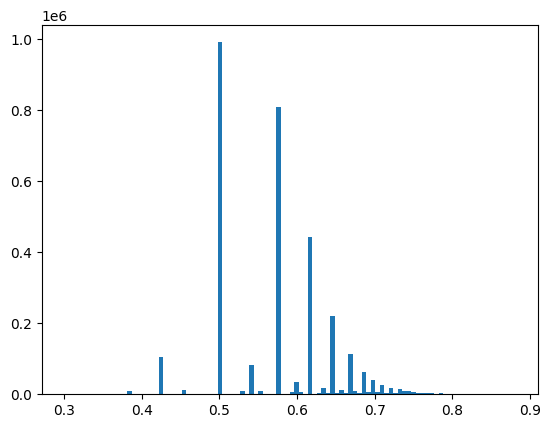

In [92]:
plt.hist(np.hstack(torch.sigmoid(hr-lr).detach().cpu().numpy()[:patch_size, : , 0]), bins=100)
plt.show()

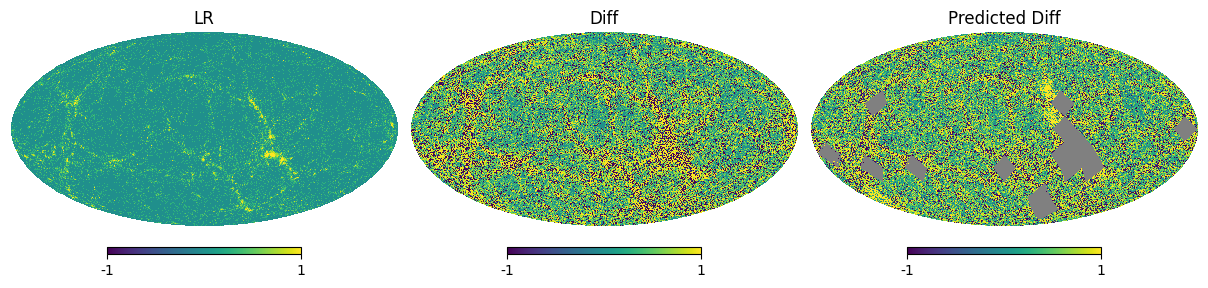

In [99]:
fig = plt.figure(figsize=(12,4))
hp.mollview(lr_hp, nest=True, fig=fig, title='LR', sub=(1,3,1), min=-1, max=1)
hp.mollview(hr_sample, nest=True, fig=fig, title='Diff', sub=(1,3,2))
hp.mollview(tmp_map, nest=True, fig=fig, title='Predicted Diff', sub=(1,3,3), min=-1, max=1)
plt.show()